# Exploring 6 Knowledge Graph Methods with LlamaIndex and NebulaGraph
# 用 LlamaIndex 和 NebulaGraph 探索 6 种知识图谱方法

**Prerequisites**:

1. Install NebulaGraph locally.[Tutorial](https://www.bilibili.com/read/cv29116537)
2. Run the notebook locally.


## Installation and Configuration

In [1]:
# !pip install llama_index==0.8.33 ipython-ngql nebula3-python pyvis networkx llama_hub unstructured --quiet

In [2]:
import os
import logging
import sys

os.environ["OPENAI_API_KEY"] = "xxx"

logging.basicConfig(stream=sys.stdout, level=logging.ERROR)

In [3]:
from llama_index import (
    LLMPredictor,
    ServiceContext,
    KnowledgeGraphIndex,
)
from llama_index.graph_stores import SimpleGraphStore
from llama_index import download_loader
from llama_index.llms import OpenAI

# define LLM
llm = OpenAI(temperature=0.1, model="gpt-3.5-turbo")
service_context = ServiceContext.from_defaults(llm=llm, chunk_size=512)

## Connect to Nebula Graph and set up a new space

In [4]:
os.environ["GRAPHD_HOST"] = "127.0.0.1"
os.environ["NEBULA_USER"] = "root"
os.environ["NEBULA_PASSWORD"] = "nebula" 
os.environ["NEBULA_ADDRESS"] = "127.0.0.1:9669"  

%reload_ext ngql
connection_string = f"--address {os.environ['GRAPHD_HOST']} --port 9669 --user root --password {os.environ['NEBULA_PASSWORD']}"
%ngql {connection_string}

In [5]:
%ngql CREATE SPACE IF NOT EXISTS tesla_10k_2022(vid_type=FIXED_STRING(256), partition_num=1, replica_factor=1);

In [4]:
%ngql SHOW SPACES;

,Name
0,demo_basketballplayer
1,tesla_10k_2022


In [5]:
%%ngql
USE tesla_10k_2022;
CREATE TAG IF NOT EXISTS entity(name string);
CREATE EDGE IF NOT EXISTS relationship(relationship string);

""


In [6]:
%ngql CREATE TAG INDEX IF NOT EXISTS entity_index ON entity(name(256));

""


In [7]:
from llama_index.storage.storage_context import StorageContext
from llama_index.graph_stores import NebulaGraphStore

space_name = "tesla_10k_2022"
edge_types, rel_prop_names = ["relationship"], ["relationship"]
tags = ["entity"]

graph_store = NebulaGraphStore(
    space_name=space_name,
    edge_types=edge_types,
    rel_prop_names=rel_prop_names,
    tags=tags,
)
storage_context = StorageContext.from_defaults(graph_store=graph_store)

## Define test dataset

In [9]:
import pandas as pd

qna_dict = {
        "What is the value of cash and cash equivalents in 2022?": "16,253 $ millions",
        "What is the value of cash and cash equivalents in 2021?": "17,576 $ millions",
        "What is the net value of accounts receivable in 2022?": "2,952 $ millions",
        "What is the net value of accounts receivable in 2021?": "1,913 $ millions",
        "What is the total stockholders' equity? in 2022?": "44,704 $ millions",
        "What is the total stockholders' equity? in 2021?": "30,189 $ millions",
        "What are total operational expenses for research and development in 2022?": "3,075 $ millions",
        "What are total operational expenses for research and development in 2021?": "2,593 $ millions",
    }

test_dataset = pd.DataFrame([qna_dict]).T.reset_index().rename(columns={'index': 'question', 0: 'expected_answer'})

In [10]:
with pd.option_context('display.max_colwidth', None):
    display(test_dataset)

,question,expected_answer
0,What is the value of cash and cash equivalents in 2022?,"16,253 $ millions"
1,What is the value of cash and cash equivalents in 2021?,"17,576 $ millions"
2,What is the net value of accounts receivable in 2022?,"2,952 $ millions"
3,What is the net value of accounts receivable in 2021?,"1,913 $ millions"
4,What is the total stockholders' equity? in 2022?,"44,704 $ millions"
5,What is the total stockholders' equity? in 2021?,"30,189 $ millions"
6,What are total operational expenses for research and development in 2022?,"3,075 $ millions"
7,What are total operational expenses for research and development in 2021?,"2,593 $ millions"


## Create KG index

In [15]:
from llama_index import load_index_from_storage
from llama_hub.file.unstructured.base import UnstructuredReader
from pathlib import Path
from llama_index import Document

try:
    storage_context = StorageContext.from_defaults(persist_dir='./storage_graph', graph_store=graph_store)
    kg_index = load_index_from_storage(
        storage_context=storage_context,
        service_context=service_context,
        max_triplets_per_chunk=15,
        space_name=space_name,
        edge_types=edge_types,
        rel_prop_names=rel_prop_names,
        tags=tags,
        verbose=True,
    )
    # vector index
    storage_context_vector = StorageContext.from_defaults(persist_dir='./storage_vector')
    vector_index = load_index_from_storage(
        storage_context=storage_context_vector,
        service_context=service_context,
    )
    
    index_loaded = True
except:
    index_loaded = False

if not index_loaded:
    
    loader = UnstructuredReader()
    documents = loader.load_data(
            file=Path(f"Tesla-10-K-2022-Filing.html") #  https://www.dropbox.com/scl/fi/fqyvmodovgk21p06giezu/Tesla-10-K-2022-Filing.html 
        )

    kg_index = KnowledgeGraphIndex.from_documents(
        documents=documents,
        storage_context=storage_context,
        max_triplets_per_chunk=15,
        service_context=service_context,
        space_name=space_name,
        edge_types=edge_types,
        rel_prop_names=rel_prop_names,
        tags=tags,
        include_embeddings=True,
    )
    kg_index.storage_context.persist(persist_dir='./storage_graph')
    
    vector_index = VectorStoreIndex.from_documents(documents)
    vector_index.storage_context.persist(persist_dir='./storage_vector')

## Define query_with_engine function


In [16]:
import pandas as pd
from tqdm import tqdm
import time

def query_with_engine(test_dataset, query_engine):

    """Query questions with a progress bar, total time cost, and individual query times.

       Args:
           qna_dict: A dictionary of questions and expected answers.
           query_engine: The engine used to query for answers.

       Returns:
           A pandas DataFrame containing questions, LLM answers, expected answers, and individual query times.
    """

    answers = {'question': [], 'llm_answer': [], 'expected_answer': [], 'query_time': []}

    start_time = time.time()

    with tqdm(total=len(test_dataset), unit="question") as pbar:
        for _,(question, expected_answer) in test_dataset.iterrows():
            start_query_time = time.time()

            try:
                response = query_engine.query(question)
                answers['question'].append(question)
                answers['llm_answer'].append(response.response)
                answers['expected_answer'].append(expected_answer)
            except Exception as e:
                answers['question'].append(question)
                answers['llm_answer'].append(str(e))
                answers['expected_answer'].append(expected_answer)

            query_time = time.time() - start_query_time
            answers['query_time'].append(query_time)
            print(f"Query time for '{question}': {query_time:.2f} seconds")  # Print individual query time
            pbar.update(1)

    end_time = time.time()
    total_time = end_time - start_time

    answers_df = pd.DataFrame(answers)

    print(f"Total time taken: {total_time:.2f} seconds")

    return answers_df


## Create CustomRetriever to combine vector index and KG index

[Article](https://www.bilibili.com/read/cv29496037)

In [17]:
from llama_index import QueryBundle
from llama_index.schema import NodeWithScore
from llama_index.retrievers import BaseRetriever, VectorIndexRetriever, KGTableRetriever
from typing import List

class CustomRetriever(BaseRetriever):
    """Custom retriever that performs both Vector search and Knowledge Graph search"""

    def __init__(
        self,
        vector_retriever: VectorIndexRetriever,
        kg_retriever: KGTableRetriever,
        mode: str = "OR",
    ) -> None:
        """Init params."""

        self._vector_retriever = vector_retriever
        self._kg_retriever = kg_retriever
        if mode not in ("AND", "OR"):
            raise ValueError("Invalid mode.")
        self._mode = mode

    def _retrieve(self, query_bundle: QueryBundle) -> List[NodeWithScore]:
        """Retrieve nodes given query."""

        vector_nodes = self._vector_retriever.retrieve(query_bundle)
        kg_nodes = self._kg_retriever.retrieve(query_bundle)

        vector_ids = {n.node.node_id for n in vector_nodes}
        kg_ids = {n.node.node_id for n in kg_nodes}

        combined_dict = {n.node.node_id: n for n in vector_nodes}
        combined_dict.update({n.node.node_id: n for n in kg_nodes})

        if self._mode == "AND":
            retrieve_ids = vector_ids.intersection(kg_ids)
        else:
            retrieve_ids = vector_ids.union(kg_ids)

        retrieve_nodes = [combined_dict[rid] for rid in retrieve_ids]
        return retrieve_nodes

In [23]:
from llama_index import VectorStoreIndex
from llama_index import get_response_synthesizer
from llama_index.query_engine import RetrieverQueryEngine
from llama_index.retrievers import VectorIndexRetriever, KGTableRetriever

# create custom retriever
# vector_index = VectorStoreIndex.from_documents(documents)
vector_retriever = VectorIndexRetriever(index=vector_index)

kg_retriever = KGTableRetriever(
    index=kg_index, 
    retriever_mode="keyword", 
    # include_text=True,
    include_text=False
) # retriever_mode (KGRetrieverMode): Specifies whether to use keywords,
            # embeddings, or both to find relevant triplets. Should be one of "keyword",
            # "embedding", or "hybrid".
custom_retriever = CustomRetriever(vector_retriever, kg_retriever)

# create response synthesizer
response_synthesizer = get_response_synthesizer(
    service_context=service_context,
    response_mode="tree_summarize",
)

## Create 6 query engines + vector query engine

In [24]:
# 0. Raw vector index retrieval
vector_query_engine = vector_index.as_query_engine()

# 1. KG vector-based entity retrieval
kg_query_engine = kg_index.as_query_engine()

# 2. KG keyword-based entity retrieval
kg_keyword_query_engine = kg_index.as_query_engine(
    # setting to false uses the raw triplets instead of adding the text from the corresponding nodes
    include_text=False,
    # include_text=True,
    retriever_mode="keyword",
    response_mode="tree_summarize",
)

# 3. KG hybrid entity retrieval
kg_hybrid_query_engine = kg_index.as_query_engine(
    include_text=False,
    # include_text=True,
    response_mode="tree_summarize",
    embedding_mode="hybrid",
    similarity_top_k=3,
    explore_global_knowledge=True,
)

# 4. Custom combo query engine
custom_query_engine = RetrieverQueryEngine(
    retriever=custom_retriever,
    response_synthesizer=response_synthesizer,
)

# 5. KnowledgeGraphQueryEngine
from llama_index.query_engine import KnowledgeGraphQueryEngine

kgqe_query_engine = KnowledgeGraphQueryEngine(
    storage_context=storage_context,
    service_context=service_context,
    llm=llm,
    verbose=True,
)

# 6. KnowledgeGraphRAGRetriever
from llama_index.query_engine import RetrieverQueryEngine
from llama_index.retrievers import KnowledgeGraphRAGRetriever

graph_rag_retriever = KnowledgeGraphRAGRetriever(
    storage_context=storage_context,
    service_context=service_context,
    llm=llm,
    verbose=True,
)

kg_rag_query_engine = RetrieverQueryEngine.from_args(
    graph_rag_retriever, service_context=service_context
)

## Run Query Engine in batch (On Tesla-10K-2022-Filing)

In [25]:
engine_dict = {"vector_engine": vector_query_engine, 
                "kg_vector_engine": kg_query_engine, 
                "kg_keyword_engine": kg_keyword_query_engine, 
                "kg_hybrid_engine": kg_hybrid_query_engine, 
                "custom_query_engine": custom_query_engine, 
                "kgqe_query_engine": kgqe_query_engine, 
                "kg_rag_query_engine": kg_rag_query_engine
              }


In [ ]:
ans_dfs = []

for engine_name, engine in engine_dict.items():
    ans_df = query_with_engine(test_dataset, engine)
    ans_df['engine_name'] = engine_name
    ans_dfs.append(ans_df)

In [ ]:
answer_df_all = pd.concat(ans_dfs)
# answer_df_all

In [28]:
with pd.option_context('display.max_colwidth', None):
    display(answer_df_all)

,question,llm_answer,expected_answer,query_time,engine_name
0,What is the value of cash and cash equivalents in 2022?,"The value of cash and cash equivalents in 2022 is $16,253 million.","16,253 $ millions",2.139630,vector_engine
1,What is the value of cash and cash equivalents in 2021?,"The value of cash and cash equivalents in 2021 was $17,576 million.","17,576 $ millions",1.684326,vector_engine
2,What is the net value of accounts receivable in 2022?,The net value of accounts receivable in 2022 is $128 million.,"2,952 $ millions",2.037756,vector_engine
3,What is the net value of accounts receivable in 2021?,"Based on the provided context information, the net value of accounts receivable in 2021 is not mentioned.","1,913 $ millions",2.070143,vector_engine
4,What is the total stockholders' equity? in 2022?,"The total stockholders' equity in 2022 is $31,015 million.","44,704 $ millions",1.980994,vector_engine
5,What is the total stockholders' equity? in 2021?,"The total stockholders' equity in 2021 was $30,189 million.","30,189 $ millions",2.417558,vector_engine
6,What are total operational expenses for research and development in 2022?,"The total operational expenses for research and development in 2022 were $3,075 million.","3,075 $ millions",1.722692,vector_engine
7,What are total operational expenses for research and development in 2021?,"The total operational expenses for research and development in 2021 were $2,593 million.","2,593 $ millions",1.864334,vector_engine
0,What is the value of cash and cash equivalents in 2022?,"The value of cash and cash equivalents in 2022 is $16,253 million.","16,253 $ millions",5.265577,kg_vector_engine
1,What is the value of cash and cash equivalents in 2021?,"The value of cash and cash equivalents in 2021 was $17,576 million.","17,576 $ millions",4.800032,kg_vector_engine


In [ ]:
answer_df_all.to_excel('Results-for-KG(include_text=False).xlsx', index=False)

## Resutls

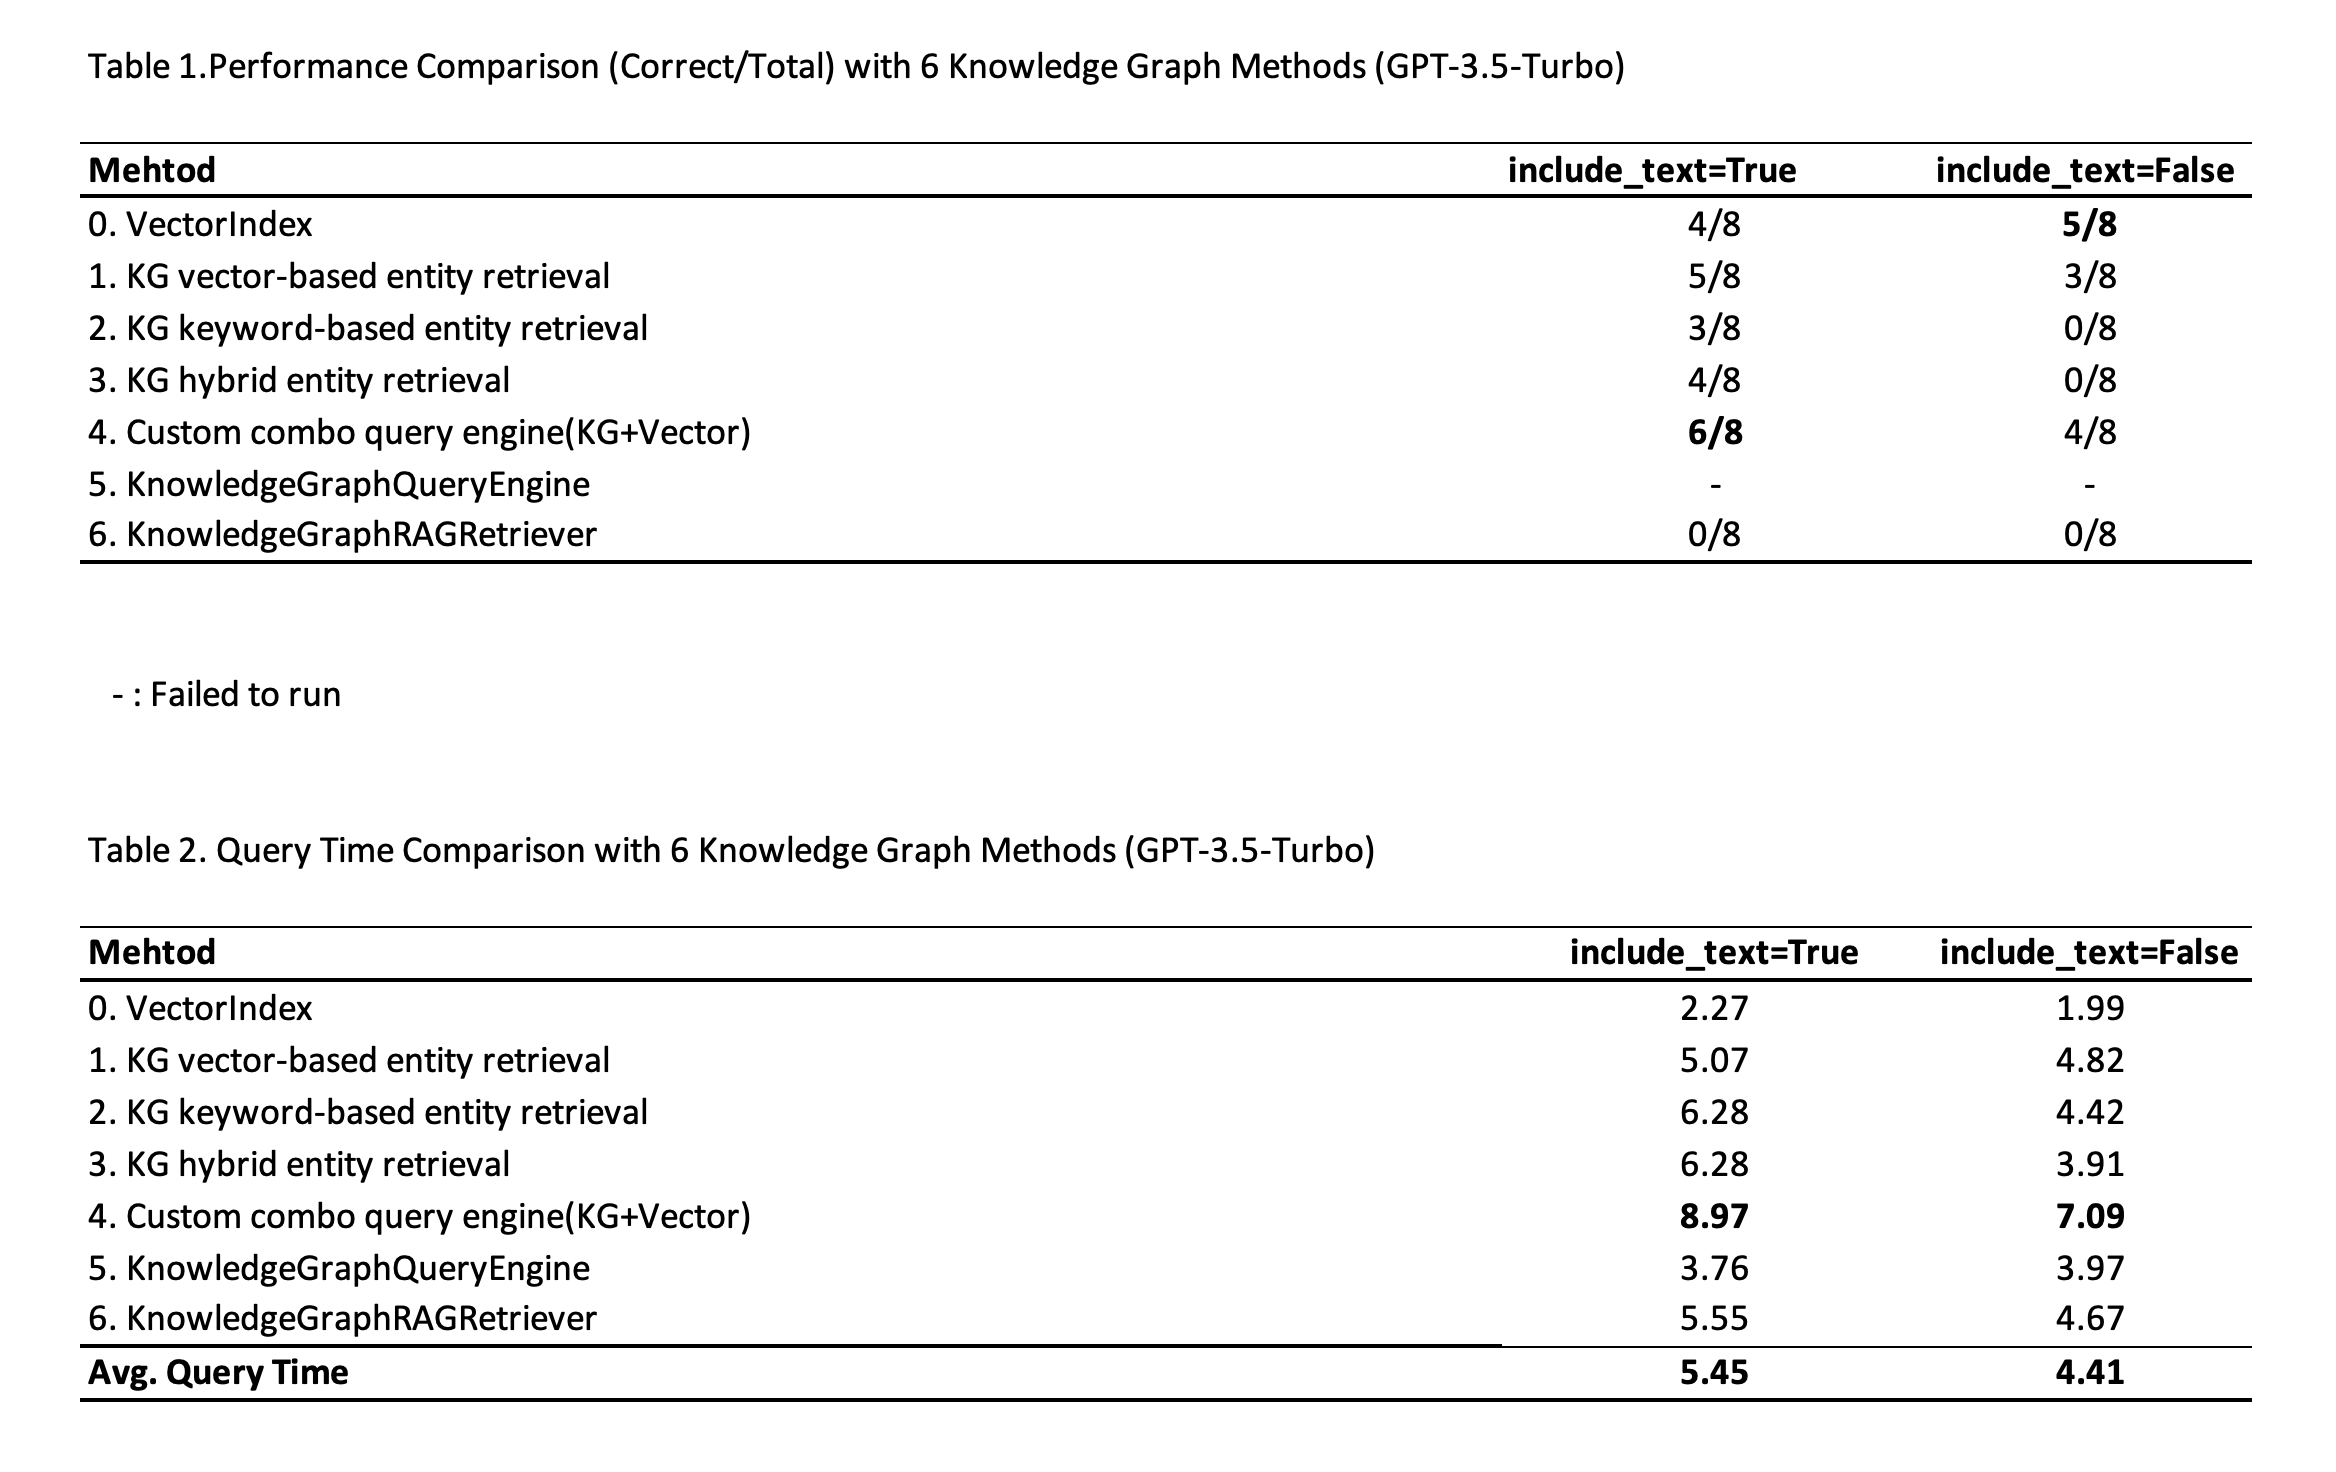

## Findings


   
1. KnowledgeGraphQueryEngine鲁棒性差，无法正常运行回答test-dataset中8个问题，这可能是自动生成的Cypher语句的问题。（部分自撰问题可运行）
   
2. KnowledgeGraphRAGRetriever无法回答对test-dataset中的8个问题，单纯的关键词实体检索效果并不好。

3. 原始向量检索Vectorindex查询时间最快`~2s`; 自定义组合查询时间最慢，`~8s`.

4. include-text参数决定查询的内容的丰富度，也影响查询引擎的性能。=True时性能比=False时性能表现更好，但是查询速度更慢。
   

## Summary


1. 知识图谱查询引擎适合需要进行复杂推理、查找实体关系的场景，例如欺诈检测、社交网络、供应链管理等。

2. 向量查询引擎适合进行相似性搜索、快速响应查询的场景。

3. 如果需要最高质量的响应，可以使用自定义组合查询引擎。

   